# EDA on time series

## Data extract / import

In [196]:
# import libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [197]:

def extract_folder(folderpath, add_scores=False, downsample=None):
    """
    Extract CSV data from folder and subfolders into a dataframe.

    Args:
      folderpath (str): Path to the folder containing CSV files.
      add_scores (bool, optional): Boolean to add scores.csv to the dataframe. Defaults to False.
      downsample (int, optional): Number of rows to downsample CSVs to. Defaults to None.

    Returns:
      pandas.DataFrame: DataFrame of concatenated CSV data.
    """
    import os
    import pandas as pd
    
    # Dict to store dataframes by condition  
    dfs = {'control': [], 'condition': []}

    try:
        # Handle top-level scores CSV
        if add_scores and 'scores.csv' in os.listdir(folderpath):
            scores_path = os.path.join(folderpath, 'scores.csv')  
            dfs['scores'] = pd.read_csv(scores_path)

        # Get subfolders
        subfolders = [f for f in os.listdir(folderpath) if os.path.isdir(os.path.join(folderpath, f))]

        for subfolder in subfolders:
            subfolderpath = os.path.join(folderpath, subfolder)  

            # Get list of CSV files
            files = os.listdir(subfolderpath)

            for file in files:
                filepath = os.path.join(subfolderpath, file)

                # Extract ID from filename 
                id = file.split('.')[0]

                df = pd.read_csv(filepath)

                # Downsample if needed
                if downsample:
                    df = df.sample(downsample)

                # Add ID column - this is the filename without the extension
                df['id'] = id

                # Add 'condition' column
                df['condition'] = subfolder

                # Convert 'timestamp' and 'date' to datetime
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df['date'] = pd.to_datetime(df['date'])

                # Append to dict by condition
                if subfolder == 'control':
                    dfs['control'].append(df)
                else:  
                    dfs['condition'].append(df)

    except OSError:
        print(f"Error reading folder: {folderpath}")

    # concatenate dfs for each condition
    dfs['control'] = pd.concat(dfs['control'])
    dfs['condition'] = pd.concat(dfs['condition'])

    # Reset index on the final df
    df = pd.concat([dfs['control'], dfs['condition']]).reset_index(drop=True)

    # add label column
    df['label'] = 0
    df.loc[df['condition'] == 'condition', 'label'] = 1
    
    # remove old 'condition' column
    df.drop('condition', axis=1, inplace=True)

    # Final concat
    return df

In [198]:
# load the data
df = extract_folder('../data/depresjon')

## Data Processing

### Extract full days only

In [199]:
# print info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1571706 entries, 0 to 1571705
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   timestamp  1571706 non-null  datetime64[ns]
 1   date       1571706 non-null  datetime64[ns]
 2   activity   1571706 non-null  int64         
 3   id         1571706 non-null  object        
 4   label      1571706 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 60.0+ MB
None


In [200]:
def extract_full_days(df):
    """
    Extracts full days from a DataFrame.

    Parameters:
    df (DataFrame): The input DataFrame.

    Returns:
    DataFrame: The DataFrame containing only full days (1440 rows per day).

    """
    # group by id and date, count rows, and filter where count equals 1440
    full_days_df = df.groupby(['id', 'date']).filter(lambda x: len(x) == 1440)

    # set index to timestamp
    full_days_df.set_index(['timestamp'], inplace=True)
    
    # print id and date combinations that don't have 1440 rows
    not_full_days = df.groupby(['id', 'date']).size().reset_index(name='count').query('count != 1440')
    print("\nid and date combinations that don't have 1440 rows and have been removed:\n")
    print(not_full_days)
    
    return full_days_df



In [201]:
full_df = extract_full_days(df)


id and date combinations that don't have 1440 rows and have been removed:

                id       date  count
0      condition_1 2003-05-07    720
16     condition_1 2003-05-23    924
17    condition_10 2004-08-31    900
32    condition_10 2004-09-15    495
33    condition_11 2004-09-28    870
...            ...        ...    ...
1101     control_7 2003-04-23    610
1102     control_8 2003-11-04    900
1122     control_8 2003-11-24    658
1123     control_9 2003-11-11    900
1143     control_9 2003-12-01    778

[115 rows x 3 columns]


In [202]:
print(full_df.head())

                          date  activity         id  label
timestamp                                                 
2003-03-19 00:00:00 2003-03-19         0  control_1      0
2003-03-19 00:01:00 2003-03-19         0  control_1      0
2003-03-19 00:02:00 2003-03-19         0  control_1      0
2003-03-19 00:03:00 2003-03-19         0  control_1      0
2003-03-19 00:04:00 2003-03-19       175  control_1      0


### Adjusting for full days with no or little activity

I noticed that even when keeping 'full days' there are instances in the data where no 'activity' is recorded for the day - or *very* little.  

For example, look at `control_1` v `condition_1` resampled to hourly frequency:

![control_1 hourly plot](./hourly_control_1.png)

![condition_1 hourly plot](./hourly_condition_1.png)

Initial investigation suggests that there needs to be some tidying up before resampling:

In [203]:
# print all ids, dates where max of activity is less than 100
print("ids, dates where min and max of activity is less than 100:")
print(full_df.groupby(['id', 'date'])['activity'].agg(['mean','min', 'max', 'sum']).query('max < 100'))



ids, dates where min and max of activity is less than 100:
                             mean  min  max    sum
id           date                                 
condition_13 2005-08-27  0.265278    0   93    382
             2005-08-28  0.201389    0   46    290
condition_16 2005-10-10  0.044444    0   58     64
             2005-10-11  0.000000    0    0      0
             2005-10-12  0.000000    0    0      0
...                           ...  ...  ...    ...
control_8    2003-11-22  0.000000    0    0      0
             2003-11-23  0.000000    0    0      0
control_9    2003-11-28  6.401389    5    7   9218
             2003-11-29  6.887500    5    7   9918
             2003-11-30  7.000000    7    7  10080

[181 rows x 4 columns]


**Plan**

1. remove all 'dates' (full days) where the 'sum' of `activity` for that date is '0'
2. remove rows where the 'sum' of `activity` for a date is lower than a percentage of the mean/median of the sum of the dataframe

#### 1. Remove where no activity by sum per day

In [204]:
# make a copy of the original dataframe
df_copy = full_df.copy()

# group by 'id' and 'date' and calculate the sum of 'activity'
df_copy['date'] = df_copy.index.date
df_sum = df_copy.groupby(['id', 'date'])['activity'].sum()

# filter out the days with zero total activity
df_sum = df_sum[df_sum != 0]

# filter the original dataframe to only include these 'id' and 'date' combinations
df_no_zero = df_copy[df_copy.set_index(['id', 'date']).index.isin(df_sum.index)]

# make date a datetime object again
df_no_zero.loc[:,'date'] = pd.to_datetime(df_no_zero['date'])



In [205]:
# is df_no_zero a subset of full_df?
print(set(df_no_zero['date']).issubset(set(full_df['date'])))


True


In [206]:
# count number of days for control 3 in full_df
print("Number of days for control_3 in full_df:")
print(full_df.query('id == "control_3"')['date'].nunique())
# count number of days for control 3 in df_no_zero
print("Number of days for control_3 in df_no_zero:")
print(df_no_zero.query('id == "control_3"')['date'].nunique())


Number of days for control_3 in full_df:
45
Number of days for control_3 in df_no_zero:
25


In [207]:
# compare number of rows in full_df and df_no_zero
print("Number of rows in full_df:")
print(len(full_df))
print("Number of rows in df_no_zero:")
print(len(df_no_zero))

Number of rows in full_df:
1481760
Number of rows in df_no_zero:
1380960


In [208]:
# print rows where sum of activity per date is zero in non-zero dataframe
print("Rows where sum of activity per date is zero in non-zero dataframe:")
print(df_no_zero.groupby(['id', 'date'])['activity'].sum()[df_no_zero.groupby(['id', 'date'])['activity'].sum() == 0])

Rows where sum of activity per date is zero in non-zero dataframe:
Series([], Name: activity, dtype: int64)


In [209]:
# print id, dates rows which were removed from df_copy
removed_rows = df_copy[~df_copy.set_index(['id', 'date']).index.isin(df_no_zero.set_index(['id', 'date']).index)].groupby(['id']).size().reset_index(name='count')

# print id, dates rows which were removed from df_copy
print("\nid, dates which were removed from df_copy:")
removed_rows['count'] = removed_rows['count'] / 1440
print(removed_rows.sort_values(by='count', ascending=False))



id, dates which were removed from df_copy:
              id  count
8      control_3   20.0
10    control_32   14.0
9     control_31   13.0
2      control_1    5.0
1   condition_20    3.0
4     control_17    3.0
6     control_21    3.0
0   condition_16    2.0
3     control_12    2.0
5     control_19    2.0
11     control_8    2.0
7     control_26    1.0


#### 2. Remove based on threshold 

In [230]:
#  dates with zero activity in df_sum
print("Dates with zero activity in df_sum:")
print(df_sum.query('activity == 0'))


Dates with zero activity in df_sum:
Empty DataFrame
Columns: [id, date, activity]
Index: []


In [213]:
# 0. make a copy of the original dataframe
df_copy = df_no_zero.copy()

# 1. calculate the sum of activity for each day for each id
df_copy['date'] = df_copy.index.date
df_sum = df_copy.groupby(['id', 'date'])['activity'].sum().reset_index()


In [251]:
# describe df_sum activity
print("Describe df_sum activity:")
print(df_sum['activity'].describe())

Describe df_sum activity:
count       959.000000
mean     277856.578728
std      194112.813975
min           3.000000
25%      113786.000000
50%      281111.000000
75%      418065.500000
max      901858.000000
Name: activity, dtype: float64


There are some very low numbers - effectively zero.

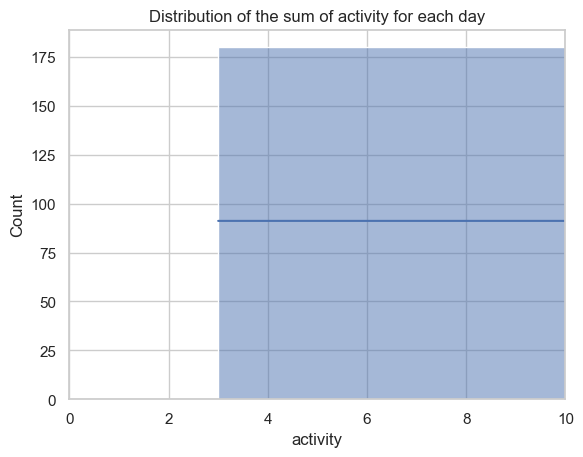

In [245]:
# plot the distribution of the sum of activity for each day
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(df_sum['activity'], kde=True)
plt.xlim(0, 10)
plt.title('Distribution of the sum of activity for each day')

plt.show()




Plotting in log scale shows the extent of almost zero counts.  Bear in mind that these are aggregated for days (not minute rows with zero).
* $10^5$ would be 100,000 (sum activity)
* $10^3$ is 1000

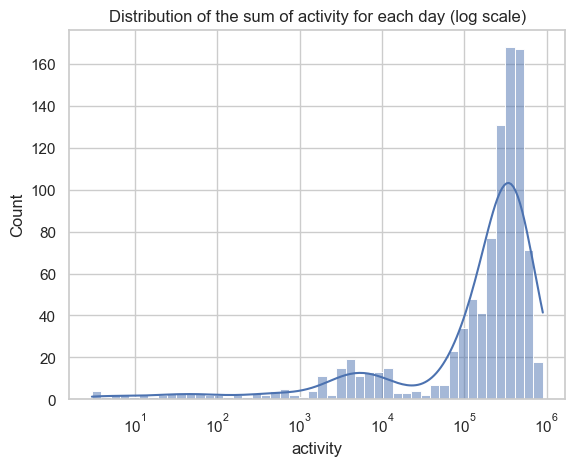

In [246]:
# plot in log scale
sns.histplot(df_sum['activity'], kde=True, log_scale=True)
plt.title('Distribution of the sum of activity for each day (log scale)')
plt.show()


Averaging the sum by date gives more evidence to removing the lower values. 

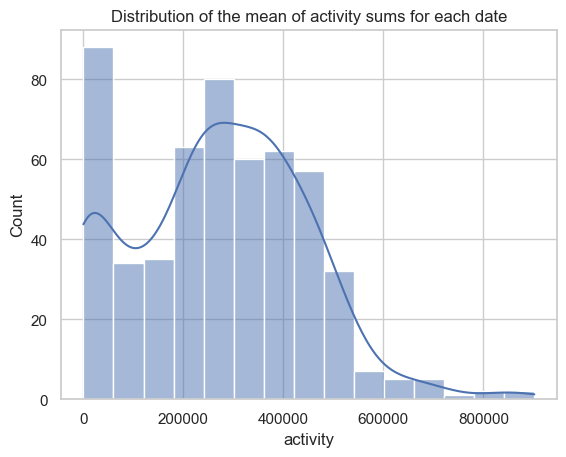

In [247]:
# calculate the mean activity sum for each date
df_mean = df_sum.groupby('date')['activity'].mean().reset_index()

# plot a histogram of the means
sns.histplot(df_mean['activity'], kde=True)
plt.title('Distribution of the mean of activity sums for each date')
plt.show()


In [264]:

# 2. calculate a threshold to apply for inclusion/exclusion
threshold = df_sum['activity'].quantile(0.05)  

# print threshold
print(threshold)


705.3000000000002


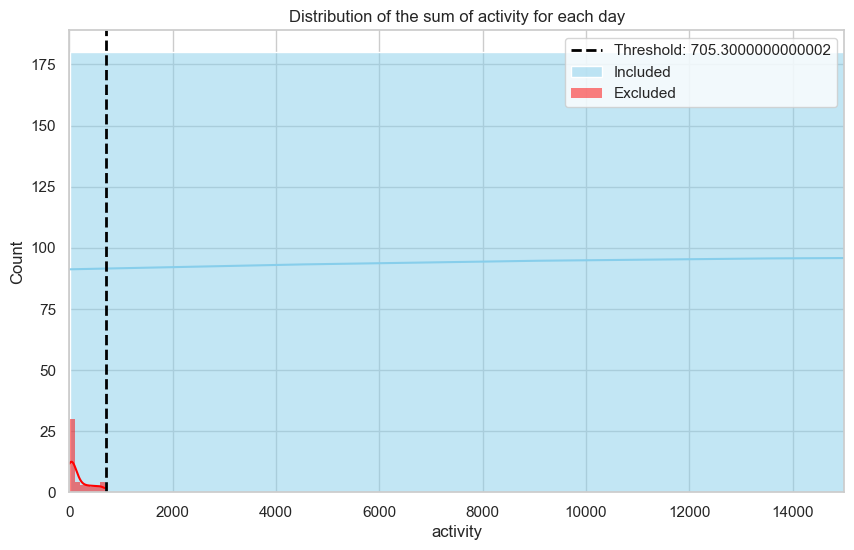

In [266]:
# plot a histogram of the sum of activity
plt.figure(figsize=(10, 6))
sns.histplot(df_sum['activity'], kde=True, color="skyblue", label='Included')
sns.histplot(df_sum[df_sum['activity'] < threshold]['activity'], kde=True, color="red", label='Excluded')
plt.axvline(threshold, color='black', linestyle='dashed', linewidth=2, label=f'Threshold: {threshold}')
plt.legend()
plt.xlim(0, 15000)
plt.title('Distribution of the sum of activity for each day')
plt.show()


Remove days where sum of activity is below threshold.

* After looking and plotting and testing...I am starting with threshold of 0.05 quantile.  
* It does not exclude many (so conservative) but when plotting it seems to cut off ok.

In [286]:
# 3. get the dates where the sum of activity for a date is higher than the threshold
# get the 'id' and 'date' for the valid rows
valid_ids_dates = df_sum[df_sum['activity'] > threshold][['id', 'date']]
#print(valid_rows)

# number of rows (day, ids) being dropped
print("\nThe number of (id, date) combinations dropped: ", len(df_sum) - valid_ids_dates.shape[0])

# print the ids and dates being dropped
print("\nThe ids and dates being dropped: ")
print(df_sum[~df_sum['date'].isin(valid_ids_dates['date'])])



The number of (id, date) combinations dropped:  48

The ids and dates being dropped: 
               id        date  activity
120  condition_16  2005-10-10        64
121  condition_16  2005-10-13        49
122  condition_16  2005-10-14        19
123  condition_16  2005-10-15       270
124  condition_16  2005-10-16       515
125  condition_16  2005-10-17       681
258  condition_23  2002-06-27       589
506    control_17  2003-12-24       462
507    control_17  2003-12-28         3
522    control_18  2004-01-24        26
538    control_19  2004-01-26       450
576    control_20  2004-02-12       323
578    control_20  2004-02-14        27
597    control_21  2004-02-12        94
670    control_26  2004-03-10        50
671    control_26  2004-03-11        63
672    control_26  2004-03-12       153
673    control_26  2004-03-13        38
736     control_3  2002-11-21       113
738     control_3  2002-11-25         4
739     control_3  2002-11-28       207
740     control_3  2002-12-04    

In [299]:
import matplotlib.pyplot as plt

def plot_activity(df, id, start_date, end_date):
    """
    Plot the activity for a specific ID within a given date range.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        id (str): The ID to plot the activity for.
        start_date (str): The start date of the date range (format: "YYYY-MM-DD").
        end_date (str): The end date of the date range (format: "YYYY-MM-DD").
    """
    filtered_df = df.query(f'id == "{id}" and date >= "{start_date}" and date <= "{end_date}"')
    
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_df.index, filtered_df['activity'])
    plt.title(f'{id} activity')
    plt.xticks(rotation=45)
    plt.show()


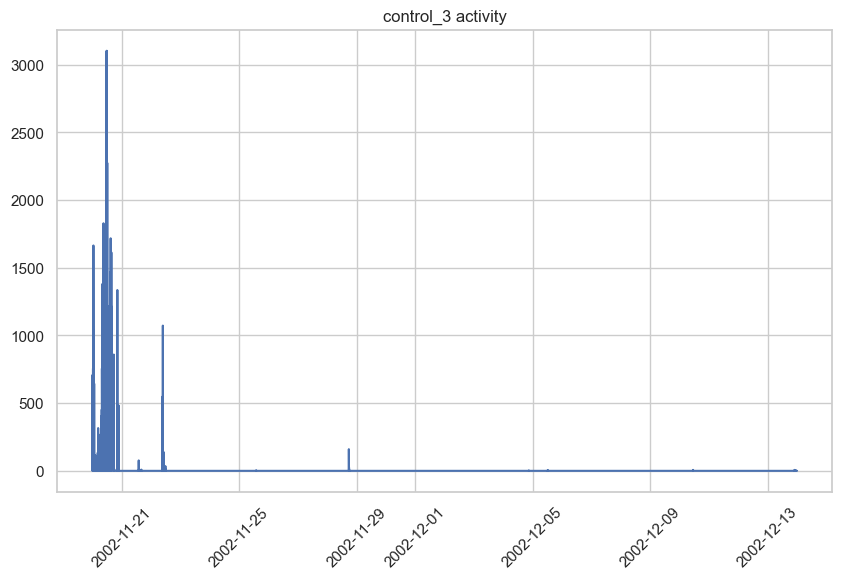

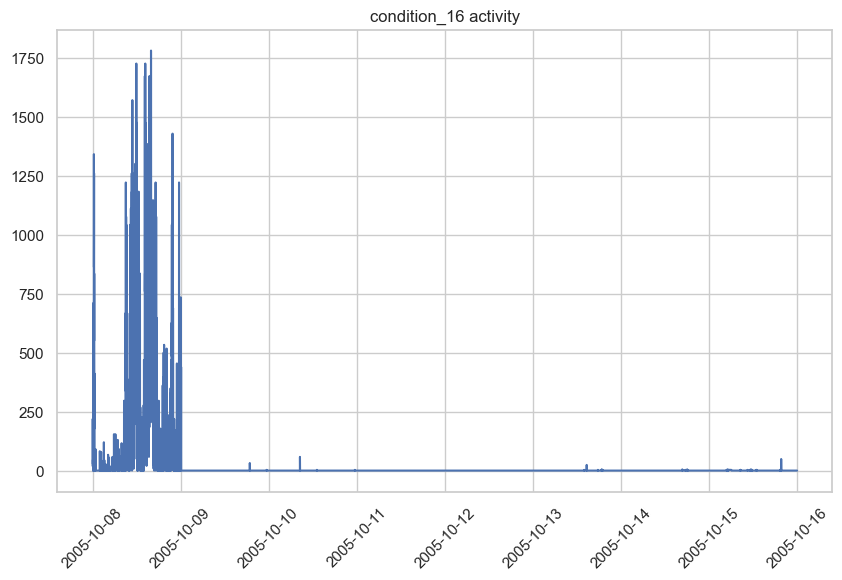

In [300]:

# plot the activity for control_3 
plot_activity(df_no_zero, 'control_3', '2002-11-20', '2002-12-14')
# plot for condition 16
plot_activity(df_no_zero, 'condition_16', '2005-10-08', '2005-10-15')


In [287]:
# 4.  filter df_no_zero to only include these 'id' and 'date' combinations
df_filtered = df_no_zero[df_no_zero.set_index(['id', 'date']).index.isin(valid_ids_dates.set_index(['id', 'date']).index)]




In [288]:
# print head of df_filtered
print(df_filtered.head())
# print info of df_filtered
print(df_filtered.info())

                                    date  activity         id  label
timestamp                                                           
2003-03-19 00:00:00  2003-03-19 00:00:00         0  control_1      0
2003-03-19 00:01:00  2003-03-19 00:00:00         0  control_1      0
2003-03-19 00:02:00  2003-03-19 00:00:00         0  control_1      0
2003-03-19 00:03:00  2003-03-19 00:00:00         0  control_1      0
2003-03-19 00:04:00  2003-03-19 00:00:00       175  control_1      0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1311840 entries, 2003-03-19 00:00:00 to 2004-06-09 23:59:00
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   date      1311840 non-null  object
 1   activity  1311840 non-null  int64 
 2   id        1311840 non-null  object
 3   label     1311840 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 50.0+ MB
None


In [290]:


# print all ids, dates where sum of activity is less than 100
print("ids, dates where min and max of activity is less than 100:")
print(df_filtered.groupby(['id', 'date'])['activity'].agg(['min', 'max', 'sum']).query('sum < 1000'))

ids, dates where min and max of activity is less than 100:
                         min  max  sum
id           date                     
condition_23 2002-06-26    0  357  955
control_18   2004-01-25    0  219  708
control_4    2002-11-16    0  751  959


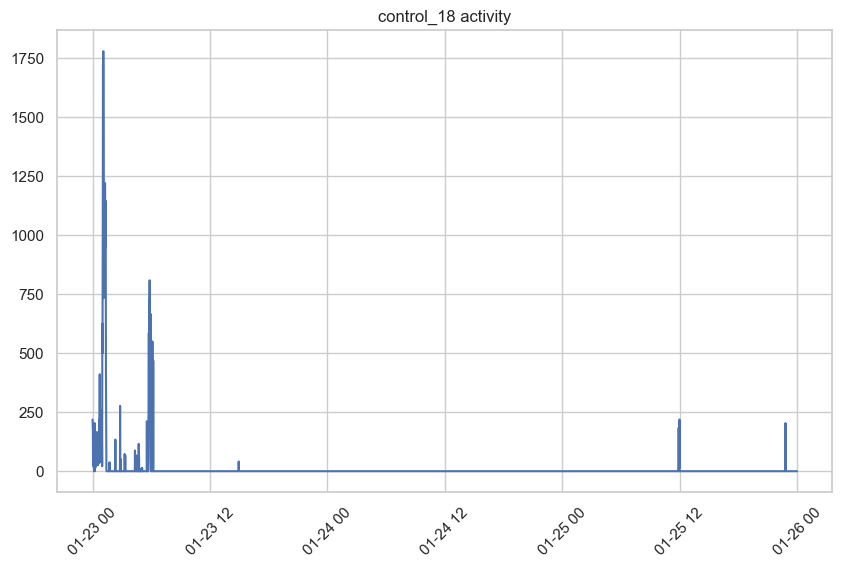

In [301]:
# plot control 18
plot_activity(df_filtered, 'control_18', '2004-01-23', '2004-02-02')

### Downsampling

In [308]:
# resample v2 - mean, median, sum
def resample2(df, resample_col, frequency):
    """
    Resamples a DataFrame based on a given timestamp column and aggregates the resampled data.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        timestamp_col (str): The name of the timestamp column in the DataFrame.
        resample_col (str): The name of the column to be resampled.
        frequency (str): The frequency at which to resample the data (e.g., 'D' for daily, 'H' for hourly).

    Returns:
        pandas.DataFrame: The resampled and aggregated DataFrame.
    """

    
    # resample data and calculate mean, sum, and median
    df_resampled = df.groupby('id')[resample_col].resample(frequency).agg(['mean', 'sum', 'median'])
    
    # reset index
    df_resampled = df_resampled.reset_index()
    
    # add label column
    df_label = df.groupby(['id', df.index.date])['label'].first()
    
    # reset index
    df_label = df_label.reset_index()
    
    # rename columns
    df_label.columns = ['id', 'date', 'label']
    
    # convert date to datetime
    df_resampled['date'] = df_resampled['timestamp'].dt.date
    
    # merge dataframes
    df_final = pd.merge(df_resampled, df_label, on=['id', 'date'])

    # change date to datetime
    df_final['date'] = pd.to_datetime(df_final['date'])
    
    return df_final


In [309]:
# resample the data into several frequencies
df = df_filtered.copy()
hour01 = resample2(df,  'activity', 'h')
hour02 = resample2(df,  'activity', '2h')
hour04 = resample2(df,  'activity', '4h')
hour06 = resample2(df,  'activity', '6h')
hour08 = resample2(df,  'activity', '8h')
hour24 = resample2(df,  'activity', 'd')
hour48 = resample2(df,  'activity', '2D')
hour96 = resample2(df,  'activity', '4D')



## Visualisation

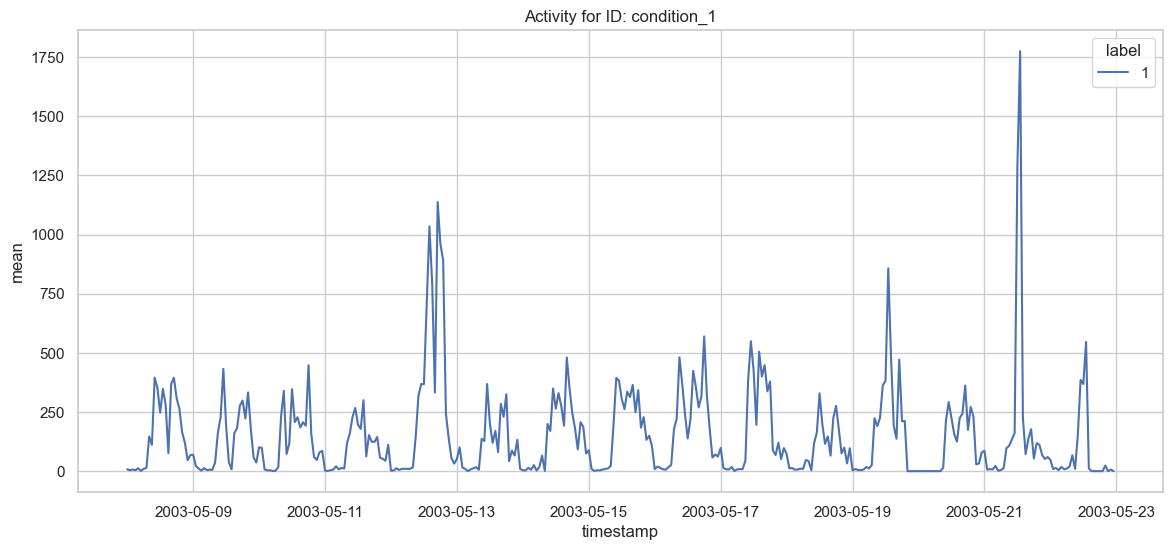

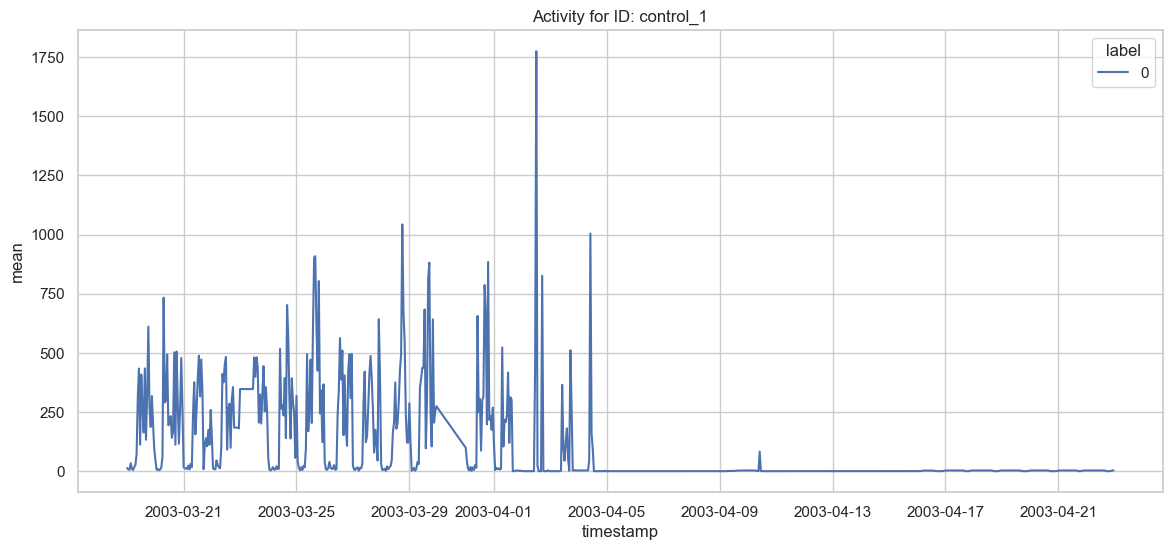

In [311]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_activity_by_id(df, id):
    plt.figure(figsize=(14, 6))
    df_id = df[df['id'] == id]
    sns.lineplot(x='timestamp', y='mean', hue='label', data=df_id)
    plt.title(f'Activity for ID: {id}')
    plt.show()

# plot for a 
plot_activity_by_id(hour01, 'condition_1')
plot_activity_by_id(hour01, 'control_1')


Despite it looking like there is no activity for `control_1` after 2003-04-04, the **daily** sum is greater than the threshold - perhaps the daily threshold needs to be higher than 700. 

In [312]:
# print sum of activity per date for control 1 from filtered df where date > 2003-04-04
print("Sum of activity per date for control 1 from filtered df where date > 2003-04-04:")
print(df_filtered.query('id == "control_1" and date > "2003-04-04"').groupby('date')['activity'].sum())

Sum of activity per date for control 1 from filtered df where date > 2003-04-04:
date
2003-04-09    2103
2003-04-10    6536
2003-04-16    1925
2003-04-17    3474
2003-04-18    3306
2003-04-19    3123
2003-04-20    3039
2003-04-21    3543
2003-04-22    3422
Name: activity, dtype: int64


In [313]:
# print sum of activity per hour for control 1 from hour01 where date > 2003-04-04
print("Sum of activity per hour for control 1 from hour01 where date > 2003-04-04:")
print(hour01.query('id == "control_1" and date > "2003-04-04"').groupby('timestamp')['sum'].sum())


Sum of activity per hour for control 1 from hour01 where date > 2003-04-04:
timestamp
2003-04-09 00:00:00      0
2003-04-09 01:00:00      0
2003-04-09 02:00:00      0
2003-04-09 03:00:00      0
2003-04-09 04:00:00      3
                      ... 
2003-04-22 19:00:00      0
2003-04-22 20:00:00      3
2003-04-22 21:00:00     60
2003-04-22 22:00:00    174
2003-04-22 23:00:00    180
Name: sum, Length: 216, dtype: int64


However, if you look at the data after resampling (hourly mean) then it no longer seems adequate/appropriate. 
* Perhaps the threshold cutoff should be done post resampling?
* Perhaps the aggregation should be `.sum()` when resampling, not `.mean()`

date
2003-03-19    11134.083333
2003-03-20    13558.875000
2003-03-21    10179.791667
2003-03-22    11021.458333
2003-03-23    20824.500000
2003-03-24    11665.416667
2003-03-25    18642.916667
2003-03-26    11971.125000
2003-03-27    10987.916667
2003-03-28    13132.333333
2003-03-29    16582.125000
2003-03-31    13920.166667
2003-04-01     6541.375000
2003-04-02     7710.083333
2003-04-03     4161.375000
2003-04-04     3333.541667
2003-04-09       87.625000
2003-04-10      272.333333
2003-04-16       80.208333
2003-04-17      144.750000
2003-04-18      137.750000
2003-04-19      130.125000
2003-04-20      126.625000
2003-04-21      147.625000
2003-04-22      142.583333
Name: sum, dtype: float64


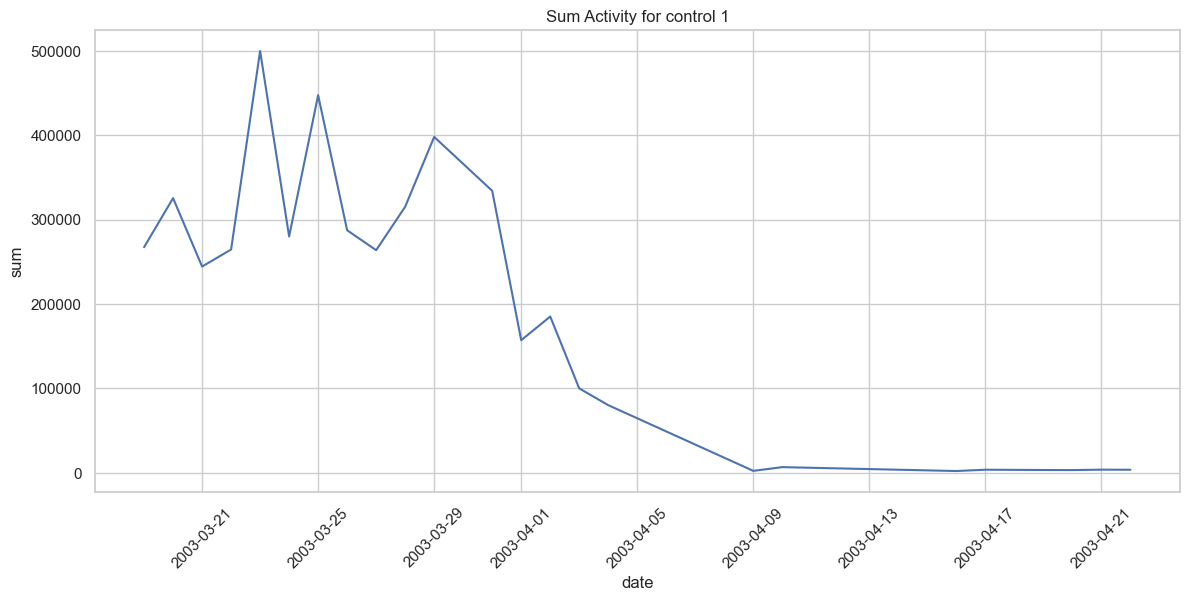

In [316]:
# print mean activity for each date for control 1
print(hour01[hour01['id'] == 'control_1'].groupby('date')['sum'].mean())

# plot sum activity for each date for condition 1
plt.figure(figsize=(14, 6))
sns.lineplot(x='date', y='sum', data=hour01[hour01['id'] == 'control_1'].groupby('date')['sum'].sum().reset_index())
plt.title('Sum Activity for control 1')
plt.xticks(rotation=45)
plt.show()


## TODO 


I am going to pause here. 

Next steps: 

**version 2**

* Move the cut off (threshold) - step 2 so that it happens post resampling
* Amend the resampling to allow for `sum` as well as `mean`

* Experiment in order to address the above issues.